In [223]:
import numpy as np
import astropy.units as u
from CenterOfMass import CenterOfMass
from ReadFile import Read
import matplotlib.pyplot as plt


In [224]:
from astropy.constants import G

G = G.to(u.kpc*u.km**2/(u.s**2 * u.Msun))

In [225]:
class MassProfile:
    def __init__(self, galaxy, snap):
        '''
        Class that calculates the Mass Profile and Rotation Curves of a given Galaxy
        in a given snapshot
        Parameters:
            galaxy [string]: a string containing the name of the galaxy
            snap [integer]: number referring to a snapshot, starts at 000
        '''
        
        ilbl = '000' + str(snap)
        
        ilbl = ilbl[-3:]
        
        self.filename="%s_"%(galaxy) + ilbl + '.txt'

        self.gname = galaxy

        self.time, self.total, self.data = Read(self.filename)

        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        self.m = self.data['m']*1e10

    def MassEnclosed(self, radii, ptype):
        '''
        Method that calculates the mass enclosed at certain radii given in an array
        Inputs:
            radii [array, astropy units of kpc]: array of numbers referring to a distance to the center of mass
            ptype [int]: number referring to the particle type (1: Halo particle, 2: Disk particle, 3: Bulge particle)
        Outputs:
            Masses_array [array, astropy unit of Msun]: An array of the masses enclosed in certain radii
        '''
        #Getting the COM position from the CenterOfMass class
        Com = CenterOfMass(self.filename, 2)
        Com_position = Com.COM_P(0.1)

        #Indexing based on particle tpye
        index = np.where(self.data['type'] == ptype)

        #Storing the values
        m_new = self.m[index]
        x_new = self.x[index] - Com_position[0]
        y_new = self.y[index] - Com_position[1]
        z_new = self.z[index] - Com_position[2]

        #Calculating the COM distance
        Com_d = np.sqrt(x_new**2 + y_new**2 + z_new**2)

        #Creating array full of zeroes to store the total mass within each radius
        Masses = np.zeros(len(radii))

        #Creating for loop for the sum of the masses
        for i in range(len(radii)):
            particle_enc = np.where(Com_d < radii[i])
            mass_enc = np.sum(m_new[particle_enc])
            Masses[i] = mass_enc

        Masses_array = np.array(Masses) * u.Msun
        return Masses_array
    
    def MassEnclosedTotal(self, radii):
        '''
        Method that calculates the total mass enclosed at certain radii
        Inputs:
            radii [array, astropy unit of kpc]: array of numbers referring to a distance to the center of mass
        Outputs:
            total_mass [array, astropy unit of Msun]: array of total masses enclosed at certain distances from
                the COM position
        '''
        #Storing values taken from the MassEnclosed method
        halo_mass = self.MassEnclosed(radii, 1)

        disk_mass = self.MassEnclosed(radii, 2)

        #If statement to account for M33 not having a bulge
        if self.gname != "M33":
            bulge_mass = self.MassEnclosed(radii, 3)
        else:
            bulge_mass = np.zeros(len(radii)) *u.Msun

        #Calculating the total mass by summing the components
        total_mass = halo_mass + disk_mass + bulge_mass

        return total_mass


    def HernquistMass(self, radii, a, Mhalo):
        '''
        Method that calculates the mass profile based on the Hernquist profile (1990)
        Inputs:
            radii [array, astropy unit of kpc]: array of numbers referring to a distance to the center of mass
            a [astropy quantity in kpc]: scale height fro the Hernquist profile
            Mhalo [astropy quantity in Msun]: Total mass of the Halo particles
        Outputs:
            Hernquist_m [array, astropy unit of Msun]: Array of masses contained in each radius
        '''
        #Numerator of the equation
        Hernquist_num = Mhalo*radii**2
        #Denominator of the equation
        Hernquist_den = (a+radii)**2
        Hernquist_m = Hernquist_num/Hernquist_den
        return Hernquist_m

    def CircularVelocity(self, radii, ptype):
        '''
        Method that calculates the Circular velocity of single particles at each distance from the COM
        Input:
            radii [array, astropy unit of kpc]: array of numbers referring to a distance to the center of mass
            ptype [int]: number referring to the particle type (1: Halo particle, 2: Disk particle, 3: Bulge particle)
        Output:
            V_circular_final [array, astropy unit of km/s]: Circular velocity of object contained within a certain radius
        '''
        #Storing the masses enclosed at a certain radius in Masses_enc
        Masses_enc = self.MassEnclosed(radii, ptype)
        #Zeros array
        V_circular = np.zeros(len(radii))
        #For loop that appends the calculated circular velocity into Total_v_circular
        for i in range(len(radii)):
            mass = Masses_enc[i]
            radius = radii[i]

            v_circular = np.sqrt(G*mass/radius) #Equation for circular velocity

            V_circular[i] = v_circular.value #Appending values

        V_circular_final = np.around(V_circular, 2) * u.km/u.s #units
        return V_circular_final

    def CircularVelocityTotal(self, radii):
        '''
        Method that calculates the total circular velocity at a certain distance form the COM
        Inputs:
            radii [array, astropy unit of kpc]: array of numbers referring to a distance to the center of mass
        Output:
            Total_v_circular_final [array, astropy unit of km/s]: Array of circular velocities of all objects
                contained withing certain radii
        
        '''
        #Storing the total mass calculated by the MassEnclosedTotal method
        TotalMass = self.MassEnclosedTotal(radii)
        #Creating zeros array
        Total_v_circular = np.zeros(len(radii))
        #For loop that appends the calculated circular velocity into Total_v_circular
        for i in range(len(radii)):
            mass = TotalMass[i]
            radius = radii[i]

            total_v_circular = np.sqrt(G*mass/radius)#Equation for circular velocity

            Total_v_circular[i] = total_v_circular.value #Appending values

        Total_v_circular_final = Total_v_circular* u.km/u.s #Units
        return Total_v_circular_final

    def HernquistVCirc(self, radii, a, Mhalo):
        '''
        Method that calculates the circular velocity given a hernquist galaxy profile
        Inputs:
            radii [array, astropy unit of kpc]: array of numbers referring to a distance to the center of mass
            a [astropy quantity in kpc]: scale height fro the Hernquist profile
            Mhalo [astropy quantity in Msun]: Total mass of the Halo particles
        Outputs:
            Total_v_circular_final [array, astropy units of km/s]: array containing tha calculated circular
                velocities of objects in a Hernquist profile scenario
            

        '''
        #Storing the total mass calculated by the HernquistMass Method
        TotalMass = self.HernquistMass(radii, a, Mhalo)
        #Zeros array
        Total_v_circular = np.sqrt(G*TotalMass/radii) #Both are already arrays
        
        Total_v_circular_final = np.around(Total_v_circular, 2)
        return Total_v_circular_final
        

### Plotting the Mass Profile of each Galaxy

In [227]:
from ComponentMassFuncs import ComponentMass

#Creating objects for the mass profiles of each galaxy
MW = MassProfile('MW', 0)
M31 = MassProfile('M31', 0)
M33 = MassProfile('M33', 0)

#Create a radii array
r = np.arange(0.1, 30, 0.2) * u.kpc

#### Milky Way Profile

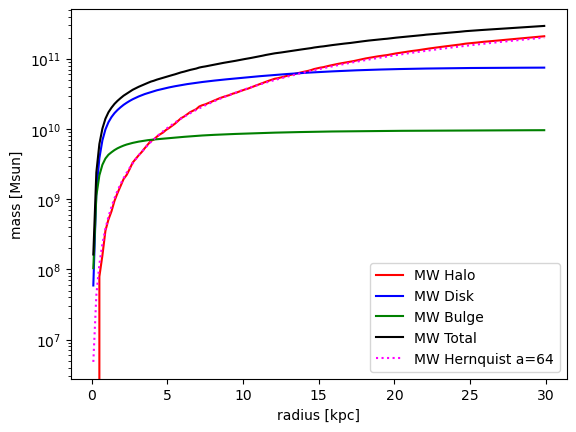

In [229]:
plt.plot(r, MW.MassEnclosed(r, 1), c='red', label='MW Halo')
plt.plot(r, MW.MassEnclosed(r, 2), c='blue', label='MW Disk')
plt.plot(r, MW.MassEnclosed(r, 3), c='green', label='MW Bulge')
plt.plot(r, MW.MassEnclosedTotal(r), c='black', label='MW Total')

MWTotalMass = ComponentMass(MW.filename, 1) *1e12*u.Msun
plt.plot(r, MW.HernquistMass(r, 64*u.kpc, MWTotalMass), c='magenta', linestyle=':', label='MW Hernquist a=64')

plt.xlabel('radius [kpc]')
plt.ylabel('mass [Msun]')
plt.semilogy()
plt.legend()
plt.show()

#### M31 Profile

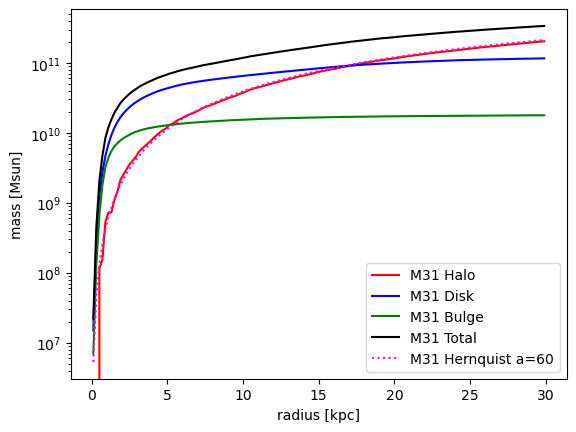

In [231]:
plt.plot(r, M31.MassEnclosed(r, 1), c='red', label='M31 Halo')
plt.plot(r, M31.MassEnclosed(r, 2), c='blue', label='M31 Disk')
plt.plot(r, M31.MassEnclosed(r, 3), c='green', label='M31 Bulge')
plt.plot(r, M31.MassEnclosedTotal(r), c='black', label='M31 Total')

M31TotalMass = ComponentMass(M31.filename, 1) *1e12*u.Msun
plt.plot(r, M31.HernquistMass(r, 60*u.kpc, M31TotalMass), c='magenta', linestyle=':', label='M31 Hernquist a=60')

plt.xlabel('radius [kpc]')
plt.ylabel('mass [Msun]')
plt.semilogy()
plt.legend()
plt.show()

#### M33 Profile

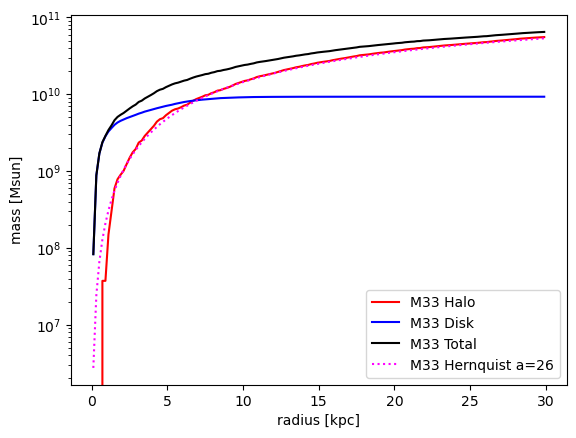

In [233]:
plt.plot(r, M33.MassEnclosed(r, 1), c='red', label='M33 Halo')
plt.plot(r, M33.MassEnclosed(r, 2), c='blue', label='M33 Disk')
plt.plot(r, M33.MassEnclosedTotal(r), c='black', label='M33 Total')

M33TotalMass = ComponentMass(M33.filename, 1) *1e12*u.Msun
plt.plot(r, M33.HernquistMass(r, 26*u.kpc, M33TotalMass), c='magenta', linestyle=':', label='M33 Hernquist a=26')

plt.xlabel('radius [kpc]')
plt.ylabel('mass [Msun]')
plt.semilogy()
plt.legend()
plt.show()

### Plotting the Rotation Curve for each Galaxy

#### MW Rotation Curve

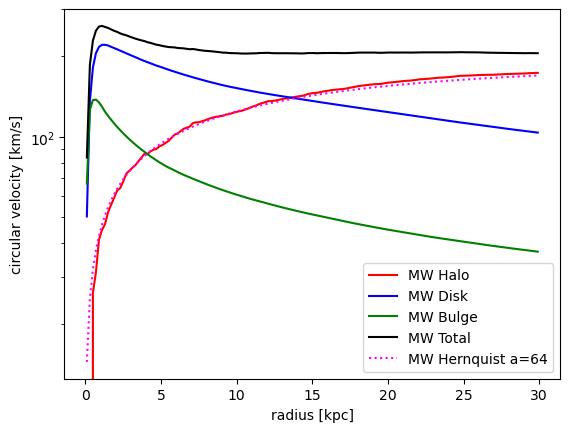

In [236]:
r = np.arange(0.1,30,0.2) * u.kpc

plt.plot(r, MW.CircularVelocity(r, 1), c='red', label='MW Halo')
plt.plot(r, MW.CircularVelocity(r, 2), c='blue', label='MW Disk')
plt.plot(r, MW.CircularVelocity(r, 3), c='green', label='MW Bulge')
plt.plot(r, MW.CircularVelocityTotal(r), c='black', label='MW Total')

MWTotalMass = ComponentMass(MW.filename, 1) *1e12*u.Msun
plt.plot(r, MW.HernquistVCirc(r, 64*u.kpc, MWTotalMass), c='magenta', linestyle=':', label='MW Hernquist a=64')

plt.xlabel('radius [kpc]')
plt.ylabel('circular velocity [km/s]')
plt.semilogy()
plt.legend()
plt.show()

#### M31 Rotation Curve

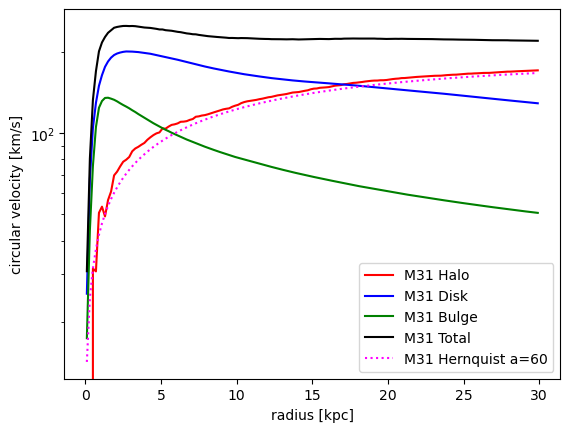

In [238]:
plt.plot(r, M31.CircularVelocity(r, 1), c='red', label='M31 Halo')
plt.plot(r, M31.CircularVelocity(r, 2), c='blue', label='M31 Disk')
plt.plot(r, M31.CircularVelocity(r, 3), c='green', label='M31 Bulge')
plt.plot(r, M31.CircularVelocityTotal(r), c='black', label='M31 Total')

M31TotalMass = ComponentMass(M31.filename, 1) *1e12*u.Msun
plt.plot(r, M31.HernquistVCirc(r, 64*u.kpc, M31TotalMass), c='magenta', linestyle=':', label='M31 Hernquist a=60')

plt.xlabel('radius [kpc]')
plt.ylabel('circular velocity [km/s]')
plt.semilogy()
plt.legend()
plt.show()

#### M33 Rotation Curve

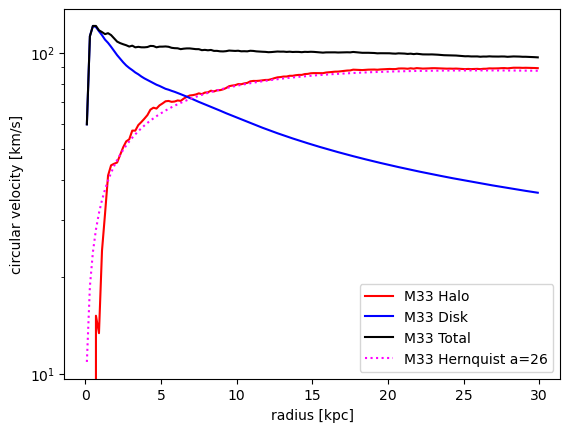

In [240]:
plt.plot(r, M33.CircularVelocity(r, 1), c='red', label='M33 Halo')
plt.plot(r, M33.CircularVelocity(r, 2), c='blue', label='M33 Disk')

plt.plot(r, M33.CircularVelocityTotal(r), c='black', label='M33 Total')

M33TotalMass = ComponentMass(M33.filename, 1) *1e12*u.Msun
plt.plot(r, M33.HernquistVCirc(r, 26*u.kpc, M33TotalMass), c='magenta', linestyle=':', label='M33 Hernquist a=26')

plt.xlabel('radius [kpc]')
plt.ylabel('circular velocity [km/s]')
plt.semilogy()
plt.legend()
plt.show()